In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append('F:/HLL/SpatialCell')
import random
random.seed(42)

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
adata = sc.read_h5ad('F:/HLL/SpatialCell/data/traingulation.h5ad')

In [3]:
from SpatialCell.tool import triangles

In [4]:
triangles.triangulation(adata)

Not enough points to calculate triangulation for ZFP36L2 in 2138935-1 TC1


In [4]:
df = adata[adata.obs['label'] == 'SPON2'].obs[['Image','triang_area']]

lower_percentile = df['triang_area'].quantile(0.01)
upper_percentile = df['triang_area'].quantile(0.8)

In [5]:
df = df[(df['triang_area'] >= lower_percentile) & (df['triang_area'] <= upper_percentile)]
df.columns = ['g','x']

mean_values = df.groupby('g')['x'].mean().sort_values(ascending=True).index
df['g'] = pd.Categorical(df['g'], categories=list(mean_values), ordered=True)
df = df.sort_values(by='g')

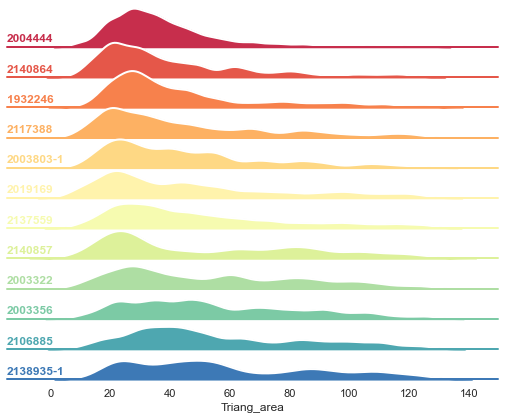

In [8]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
palette = 'Spectral'
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="g", hue="g", aspect=15, height=.5, palette=palette)

# 绘制密度图
g.map(sns.kdeplot, "x",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=.5)

# 添加参考线
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# 添加标签
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "x")

# 调整子图间距
g.figure.subplots_adjust(hspace=-.25)

# 美化图形
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

# 设置 x 轴对数刻度
# ax = plt.gca()
# ax.set_xscale("log")
plt.xlabel('Triang_area')
plt.show()

In [8]:
adata.write_h5ad('F:/HLL/SpatialCell/data/traingulation.h5ad')